<a href="https://colab.research.google.com/github/cwru-commlab/sdr-basic/blob/main/Diode_demodulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Full-carrier, double-sideband AM signal generation and demodulation.**

Software implementation of simple diode demodulator.

Set up an amplitude-modulated carrier.


Carrier frequency is chosen to simulate CW receiver 1000 Hz audio

Modulation frequency is chosen to simulate "soft" 12 WPM Morse.

Both frequencies may be changed to simulate audio on medium-wave AM or 455 kHz intermediate frequency or whatever is needed.






Run it through a diode detector.

Started 26 November 2023

Pinned a version 15 November 2024 after discussion with Costas array group and some clarifying comments.

TODO: Get audio reproduction working properly--noise case might just be showing masking.

TODO:  Implement synchronous detector, see if response to noise is much different.

DK

Imports

In [ ]:
from math import pi, sin
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from IPython.display import Audio


Numbers for carrier and sampling system

In [ ]:
F_c = 5000   # carrier frequency, hertz.  At 5000, sinusoid of carrier is not visible in graph.
omega_c = 2 * pi * F_c # same in angular frequency
T = 1/F_c    # carrier period

sample_rate = 20000 # samples per second
sample_period = 1/sample_rate

Set up 10 seconds of carrier

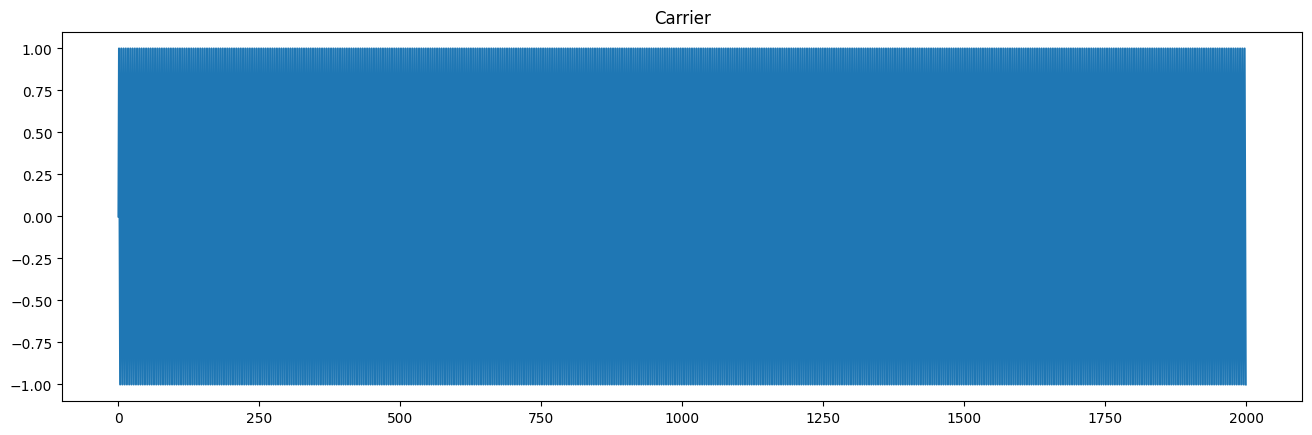

In [ ]:
epoch_time = 10 # seconds
carrier = np.empty(epoch_time*sample_rate)
for i, x in enumerate (carrier):
  t=i*sample_period               # time moving along in sample ticks
  carrier[i]=sin(2*pi*F_c * t)    # sinusoid carrier
plt.figure().set_figwidth(16)
plt.title("Carrier")
plt.plot(carrier[:2000])          # graph some of it.

Prepare modulating signal

Can set modulation index; as it approaches 1, note that the diode detector "bottoms out." The appearance of this is worse than the effect, as seen in the spectral display.

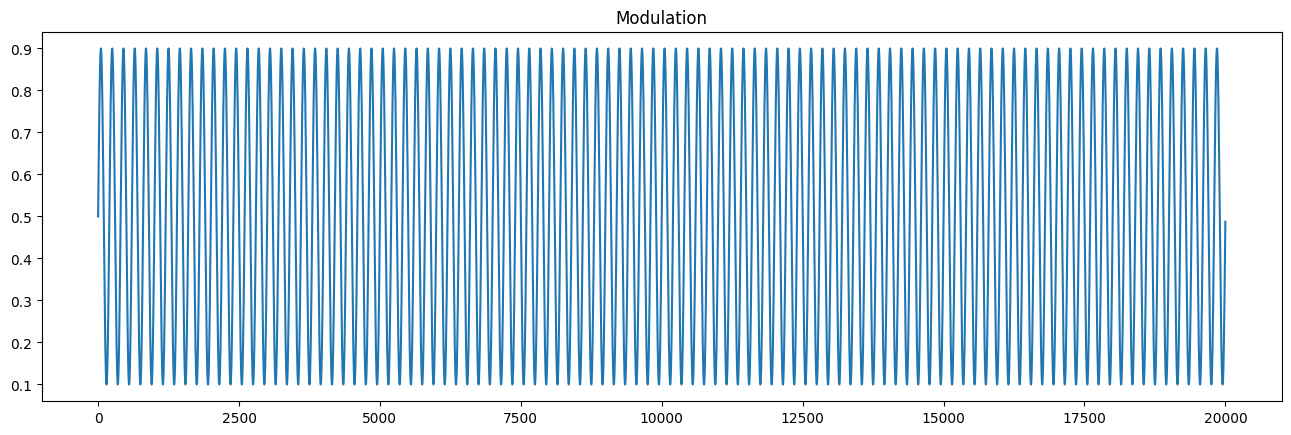

In [ ]:
f_s = 100  # hertz, appropriate for CW at 12 WPM
k = 0.8     # modulation index, zero to 1 for no modulation to 100%
modulation = np.empty(epoch_time*sample_rate)
for i, x in enumerate (modulation):
  t=i*sample_period               # time moving along in sample ticks
  modulation[i]=sin(2*pi*f_s * t)     # sinusoid carrier.  Range [-1 1] so needs adjustment
modulation += 1                       # Make modulation never negative, for full-carrier double-sideband
modulation /= 2                       # Set up for 100% modulation of carrier
modulation *= k                       # and reduce modulation as desired, k= zero to 1
                                      # TODO: this only scales amplitude, we should add/subtract a term instead (TNX, AC8XY)
modulation += 0.1
plt.figure().set_figwidth(16)
plt.title("Modulation")
plt.plot(modulation[:20000])          # graph same amount of it graphed for carrier


Multiply carrier by signal to obtain full-carrier AM

Graph the resulting DSB-FC signal.

Note that there is no phase reversal at the low amplitude points.

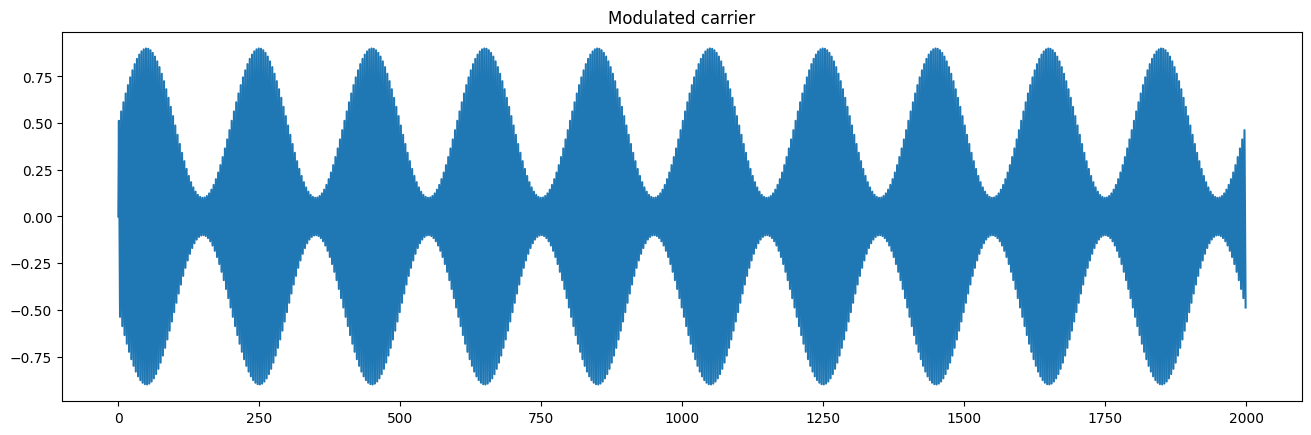

In [ ]:
signal_t = carrier * modulation
plt.figure().set_figwidth(16)
plt.title("Modulated carrier")
plt.plot(signal_t[:2000])


Rectify the signal (here, *full*-wave rectification. Note that simple diode detectors are *half*-wave rectifiers).  This is the necessary nonlinear step. It will generate the baseband signal *plus* a signal at twice the carrier frequency, by image-aliasing.  That signal may be filtered out.

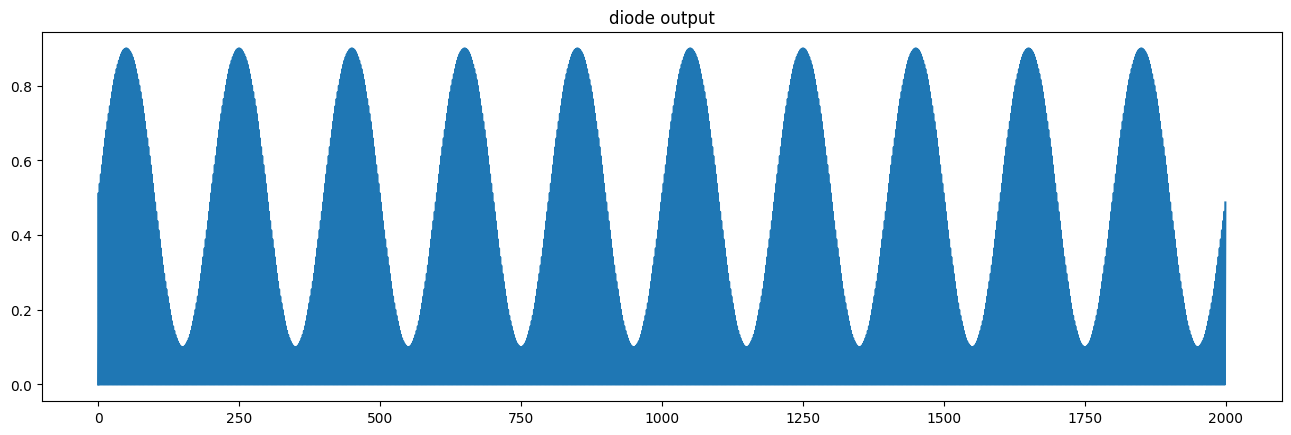

In [ ]:
rect_signal=np.absolute(signal_t)
plt.figure().set_figwidth(16)
plt.title("diode output")
plt.plot(rect_signal[:2000])


Filter to remove the image signal.

Use first-order lowpass filter, capacitor and and load resistor in parallel, with output of diode connected to top of that pair.

Set breakpoint frequency appropriate to remove the carrier second harmonic as created by the full-wave rectifier.

To simulate rectifier/filter in discrete time, compute droop of signal between samples at the computed breakpoint timing.

In [ ]:
tau=.5/(2.*pi*f_s)   # first-order lowpass breakpoint filtering set for anticipated modulation frequency
droop=np.exp(-sample_period/tau) # fraction by which filter will discharge between samples
print('droop=', droop, 'over', sample_period, 'seconds')

droop= 0.9391013674242926 over 5e-05 seconds


Apply filter to the signal.  The nonobvious part is the for loop; the capacitor's state is compared with the value of the incoming signal and the maximum of the two becomes the new, filtered signal.  The capacitor leaks its energy (state) into the load resistor, forming the R-C time constant or 1/(RC) breakpoint frequency.

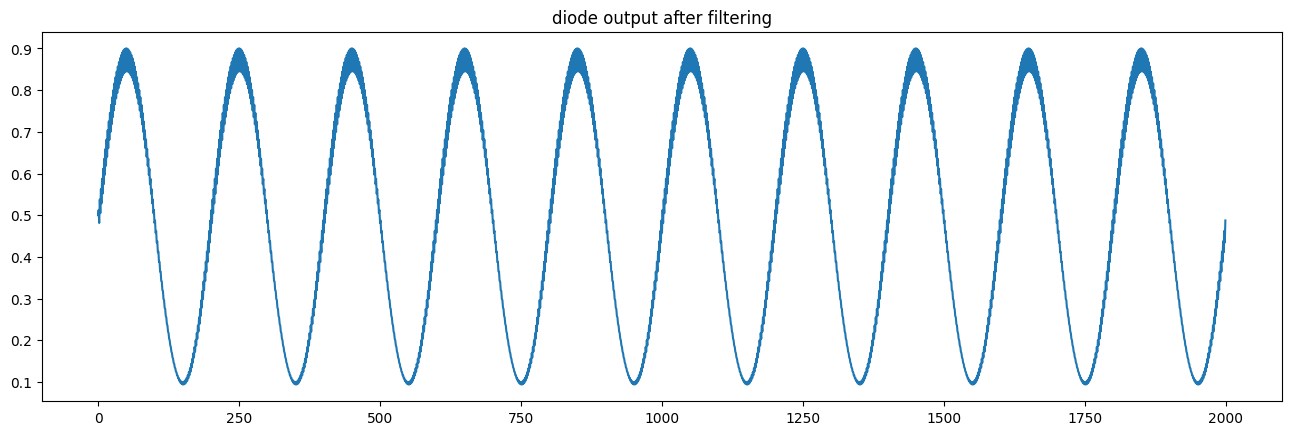

In [ ]:
filtered_signal=np.empty(epoch_time*sample_rate)  # same size as the other arrays
filtered_signal[0]=0.5                            # initialize the filter
for i in range (1,filtered_signal.size):
  filtered_signal[i]= max(filtered_signal[i-1]*droop, rect_signal[i]) # capacitor+resistor acts as leaky sample-and-hold

plt.figure().set_figwidth(16)
plt.title("diode output after filtering")
plt.plot(filtered_signal[:2000])
plt.show()

Note the small remaining harmonic content at the bottom of the demodulated cycle, when using modulation near 100%.

Plot power spectrum with DC component removed.  The remaining small harmonic content may be seen on the spectrum graph.  It could be reduced by use of a more sophisticated lowpass filter or by using a different type of AM detector, such as a phase-locked loop synchronous detector.  The diode detector with simple filter is adequate for a wide variety of communications uses, though.

The signal's mean is removed, so the zeroth DFT bin is zero here and in the noise version.

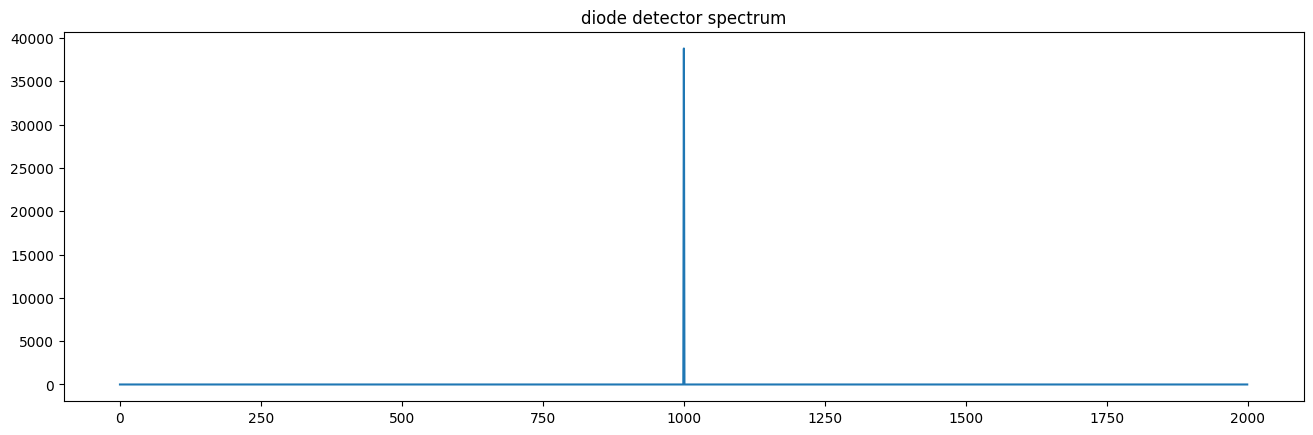

In [ ]:
# remove DC component
zero_meaned_filtered_signal = filtered_signal-np.average(filtered_signal)
frequencies=np.abs(np.fft.fft(zero_meaned_filtered_signal))   # absolute value gives power spectrum


top_displayed_frequency = 2000
plt.figure().set_figwidth(16)
plt.title("diode detector spectrum")
plt.plot(frequencies[:top_displayed_frequency])
plt.show()

In [ ]:
# Generate sound from "frequencies" array in above code cell

import numpy as np
from scipy.io.wavfile import write

# Assuming 'frequencies' is already defined from the previous code cell
# and contains the frequency domain representation of the audio signal.

# Convert the frequency domain representation back to the time domain
# using the inverse fast Fourier transform (IFFT).
audio_signal = np.fft.ifft(frequencies).real  # Extract the real part

# Normalize the audio signal to the range [-1, 1]
audio_signal = audio_signal / np.max(np.abs(audio_signal))

# Define the sample rate (same as used in the original code)
sample_rate = 20000

# Convert the audio signal to 16-bit PCM format for WAV file output
scaled_audio = np.int16(audio_signal * 32767)

# Write the audio data to a WAV file
write('audio.wav', sample_rate, scaled_audio)

# Play the audio in Colab
from IPython.display import Audio
Audio('audio.wav')

Generate some noise

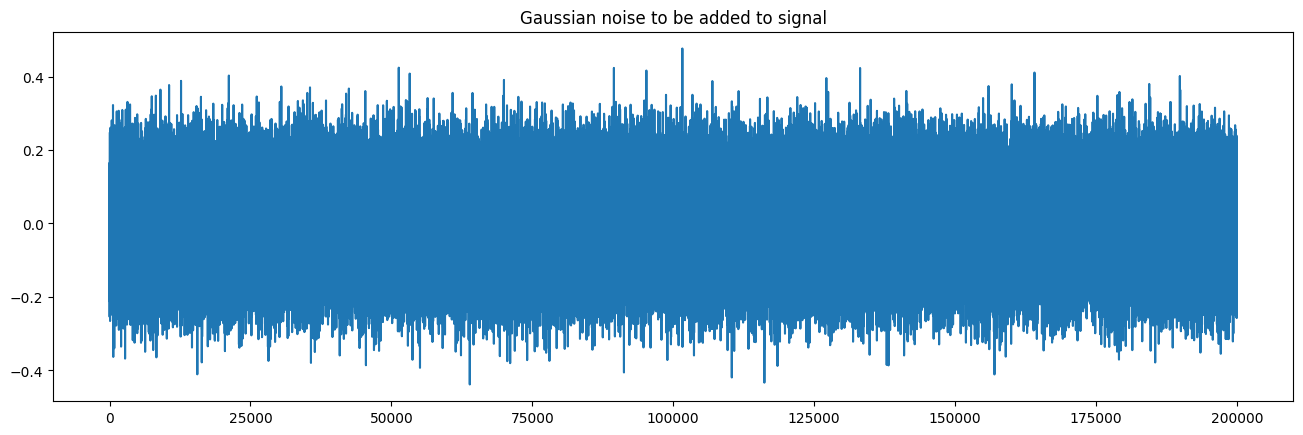

In [ ]:
noise_level = .1  # use 1 for noise level comparable to signal

noise = np.random.normal(0,noise_level,carrier.size)
plt.figure().set_figwidth(16)
plt.title("Gaussian noise to be added to signal")
plt.plot(noise)
plt.show()

Add broadband noise to the modulated signal, such as signal plus noise might be received.

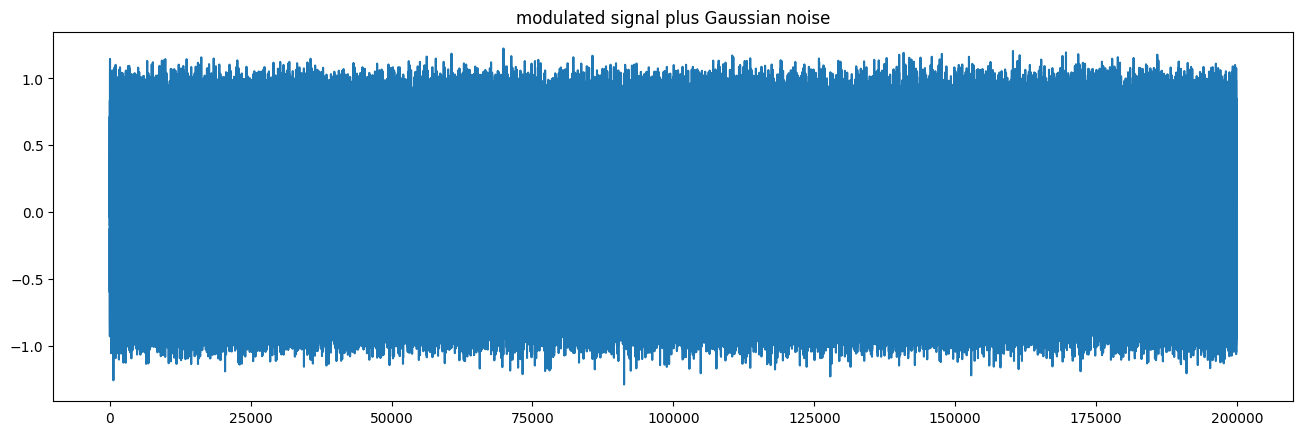

In [ ]:
signal_t = signal_t + noise
plt.figure().set_figwidth(16)
plt.title("modulated signal plus Gaussian noise")
plt.plot(signal_t)
plt.show()

Demodulate as before.

The time-domain signal looks pretty bad; the spectrum not so much so.

Try changing noise_level above.

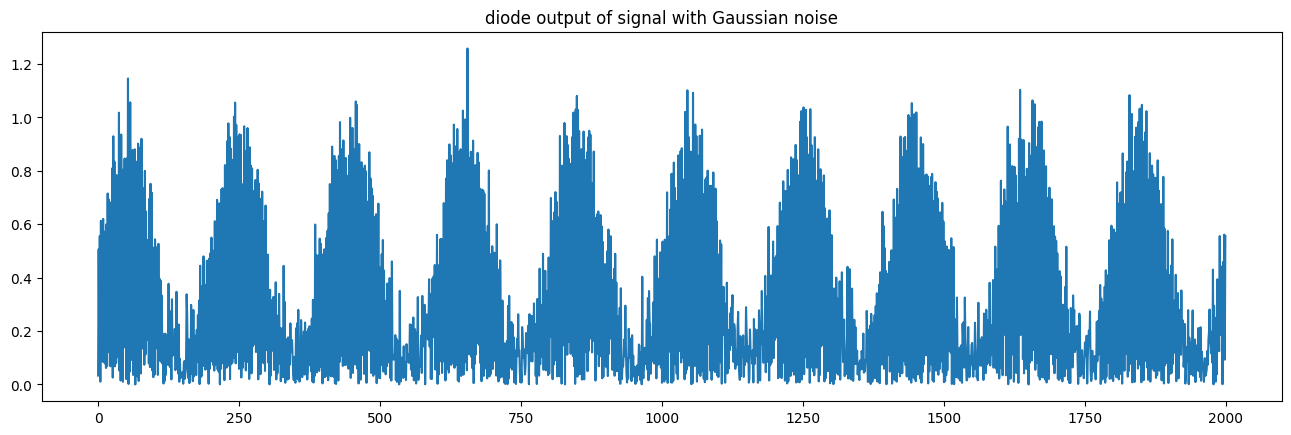

In [ ]:
rect_signal=np.absolute(signal_t) # rectify the signal and plot
plt.figure().set_figwidth(16)
plt.title("diode output of signal with Gaussian noise")
plt.plot(rect_signal[:2000])


Create a first-order lowpass filter appropriate for the demodulation.

Apply it to the diode-detected signal and graph.

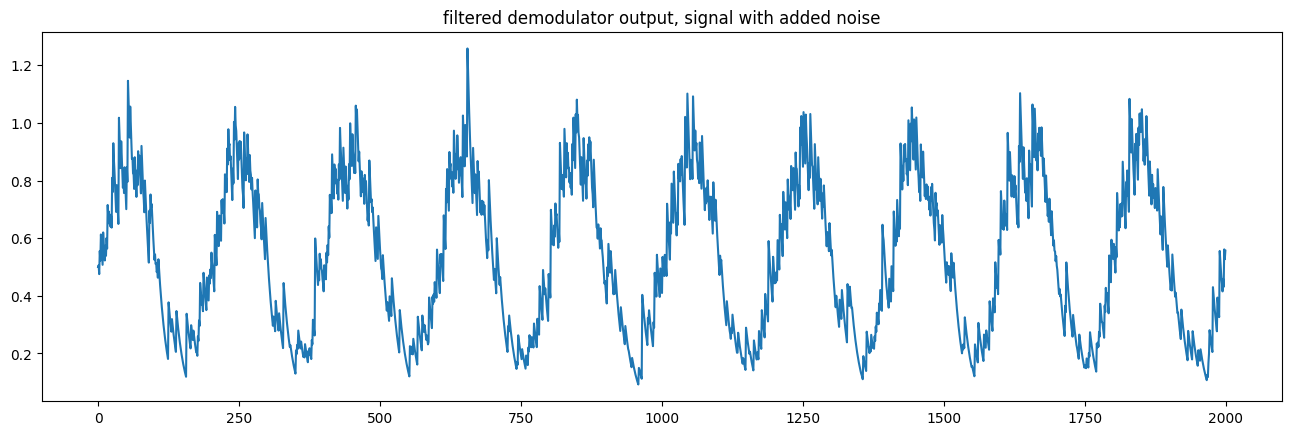

In [ ]:
# create a first-order lowpass filter.  Set the breakpoint frequency by filter time constant.
tau=.5/(2.*pi*f_s)   # first-order lowpass breakpoint filtering, set for anticipated modulation frequency
droop=np.exp(-sample_period/tau) # fraction by which filter will discharge between samples

filtered_signal=np.empty(epoch_time*sample_rate)  # same size as the other arrays
filtered_signal[0]=0.5                            # initialize the filter
for i in range (1,filtered_signal.size):
  filtered_signal[i]= max(filtered_signal[i-1]*droop, rect_signal[i]) # capacitor+resistor acts as leaky sample-and-hold

plt.figure().set_figwidth(16)
plt.title("filtered demodulator output, signal with added noise")
plt.plot(filtered_signal[:2000])
plt.show()


Remove the mean from the demodulated signal and display the resulting spectrum.

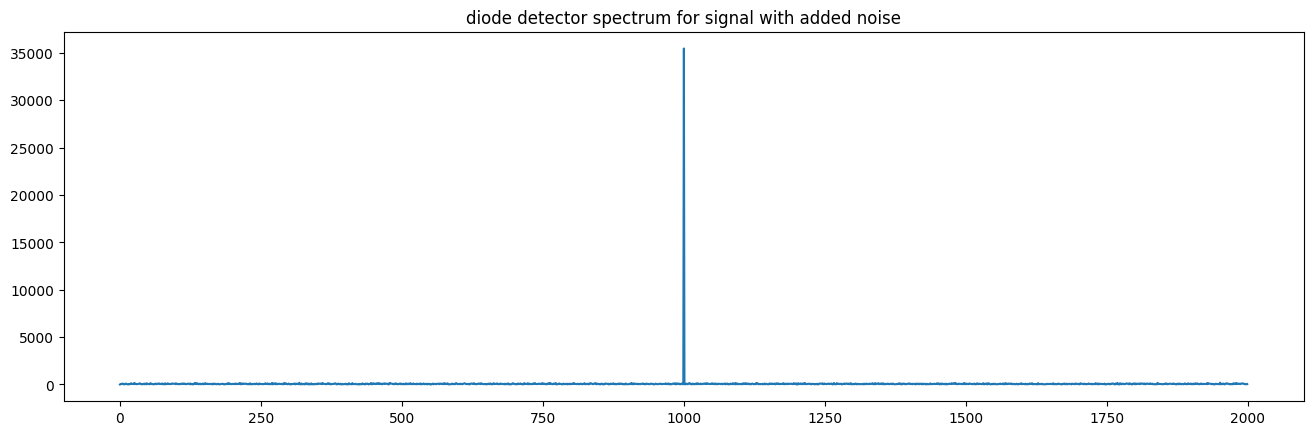

In [ ]:
zero_meaned_filtered_signal = filtered_signal - np.average(filtered_signal)
frequencies=np.abs(np.fft.fft(zero_meaned_filtered_signal))   # absolute value gives power spectrum

plt.figure().set_figwidth(16)
plt.plot(frequencies[:top_displayed_frequency])
plt.title("diode detector spectrum for signal with added noise")
plt.show()

In [ ]:
# Generate sound from "frequencies" array in above code cell

import numpy as np
from scipy.io.wavfile import write

# Assuming 'frequencies' is already defined from the previous code cell
# and contains the frequency domain representation of the audio signal.

# Convert the frequency domain representation back to the time domain
# using the inverse fast Fourier transform (IFFT).
audio_signal = np.fft.ifft(frequencies).real  # Extract the real part

# Normalize the audio signal to the range [-1, 1]
audio_signal = audio_signal / np.max(np.abs(audio_signal))

# Define the sample rate (same as used in the original code)
sample_rate = 20000

# Convert the audio signal to 16-bit PCM format for WAV file output
scaled_audio = np.int16(audio_signal * 32767)

# Write the audio data to a WAV file
write('audio.wav', sample_rate, scaled_audio)

# Play the audio in Colab
from IPython.display import Audio
Audio('audio.wav')